In [58]:
import pandas as pd

df = pd.read_csv("/Users/pablo/Downloads/2008.csv")
df = df[df["Dest"] == 'JFK']
df["Date"] = pd.to_datetime(df.Year*100000000+df.Month*1000000+df.DayofMonth*10000+df.CRSArrTime, format='%Y%m%d%H%M')
#df["Date"] = pd.to_datetime("{y}{m:02d}{d:02d}".format(y=df.Year, m=df.Month, d=df.DayofMonth), format='%Y%m%d')
drop_list = ["FlightNum", "DepTime", "ArrTime", "UniqueCarrier", "FlightNum", "Cancelled", 
             "CancellationCode", "Diverted", "TailNum", "ActualElapsedTime", "AirTime", 
             "TaxiIn", "TaxiOut", "CRSDepTime", "DepDelay", "CarrierDelay", "WeatherDelay", 
             "NASDelay", "SecurityDelay", "LateAircraftDelay", "CRSElapsedTime",
             "Year", "Month", "DayofMonth", "CRSArrTime"]

df.drop(drop_list, axis=1, inplace=True)

df.dropna(axis=0, inplace=True)
df['ctime'] = df['Date'].map(lambda x: (x.hour / 24.0) * 360)
df['cwday'] = df['DayOfWeek'].map(lambda x: int(x / 7.0 * 360)%360)
df['cdate'] = df['Date'].map(lambda x: (x.timetuple().tm_yday / 365.0)*360.0)
df['cdate'] = df['cdate'].map(lambda x: int(10 * round(float(x)/10)))
df.drop(["DayOfWeek", "Origin", "Dest", "Date"], axis=1, inplace=True)
df = df[df["ArrDelay"] > 0]

In [59]:
df.to_csv("/Users/pablo/github/circular_tree/datasets/delays_hope.csv", index=False)

df.head()

,ArrDelay,Distance,ctime,cwday,cdate
129224,17,541,165,102,0
129920,37,541,165,154,0
129921,55,541,225,154,0
129922,22,541,330,154,0
130667,17,541,165,205,0


   tilt  prec       rad
0    90   270  0.000000
1    90   270  0.000007
2    90   270  0.000027
3    90   270  0.000061
4    90   270  0.000109


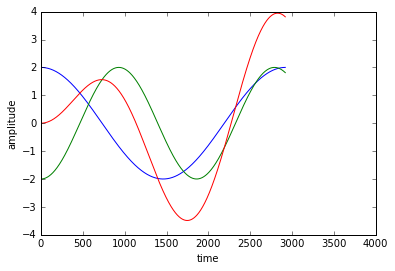

array([270, 270, 270, ..., 110, 110, 110])

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_wave(f, A, phi, points):
    t = np.arange(0, points, 1)
    x = t * f
    y = A * np.sin(2 * np.pi * x/points + phi)
    return y, np.remainder(np.degrees(2 * np.pi * x/points + phi), 360).astype(np.int) / 10 * 10


points = 365 * 8
tilt, tilt_phase = get_wave(1, 2, np.pi/2, ctime.shape[0]) 
prec, prec_phase = get_wave(1.57, 2, 3*np.pi/2, ctime.shape[0])

stack = np.concatenate([tilt_phase[...,np.newaxis], prec_phase[...,np.newaxis], 
                        (tilt+prec)[...,np.newaxis]], axis=1)

df = pd.DataFrame(stack, columns=['tilt', 'prec', 'rad'])
df.to_csv("/Users/pablo/github/circular_tree/datasets/false_hope.csv", 
          header=['tilt', 'prec', 'rad'], index=False)

print df.head()

plt.plot(np.arange(0, points, 1), tilt)
plt.plot(np.arange(0, points, 1), prec)
plt.plot(np.arange(0, points, 1), prec+tilt)
plt.axis([0, 4000, -4, 4])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

prec_phase

In [44]:
import pandas as pd

class Data(object):
    __class_description__ = """Class modelling Data a Binary Tree based on Pandas DataFrame"""
    __version__ = 0.1

    def __init__(self, df, class_var, var_desc):  # , first=True):
        self.df = df.copy()
        # self.df.dropna(inplace=True)

        # Dict with the info of input variables
        self.var_desc = var_desc
        self.class_var = class_var

        # This is here because we need a persistent way of traversing the variables (for the iterators)
        self.input_vars = list(self.var_desc.keys())

        self.iter_i = [None, None]
        self.iter_var = None
        self.iter_idx = [None]

    def sort_by(self, col_name):
        self.df = self.df.sort_values(col_name)

        if self.var_desc[col_name]["type"] == 'cir':
            start = self.var_desc[col_name]["bounds"][0][0]
            end = self.var_desc[col_name]["bounds"][-1][1]

            if start > end:
                self.df = self.df.query('{} <= {} <= 360.0'.format(start, col_name)).copy().append(
                    self.df.query('0.0 <= {} < {}'.format(col_name, end)).copy())

        self.df.index = range(0, len(self.df.index))

    def __iter__(self):

        self.iter_var = 0

        if self.var_desc[self.input_vars[self.iter_var]]["method"] == "classic":
            if self.var_desc[self.input_vars[self.iter_var]]["type"] == "cir" and self.var_desc[self.input_vars[self.iter_var]]["bounds"] == [[-np.inf, np.inf]]:
                self.iter_i = [0, 0]
            else:
                self.iter_i = [None, 0]
        elif self.var_desc[self.input_vars[self.iter_var]]["method"] == "subset":
            self.iter_i = [0, 0]
        else:
            raise Exception("Method not recognised.")

        self.sort_by(self.input_vars[self.iter_var])
        self.iter_idx = np.where(self.df[self.input_vars[self.iter_var]].values[:-1] !=
                                 self.df[self.input_vars[self.iter_var]].values[1:])[0] + 1

        return self

    def __next__(self):
        found = False

        while not found:
            self.iter_i[1] += 1

            # == modified to >=
            # if sequence is all constant self.iter_i[1] == 1 doesn't match len(self.iter_idx) == 0
            if self.iter_i[1] >= len(self.iter_idx):
                if self.iter_i[0] is None or self.iter_i[0] >= len(self.iter_idx)-1:
                    if self.iter_var < len(self.input_vars):
                        self.iter_var += 1
                        if self.iter_var == len(self.input_vars):
                            raise StopIteration
                        else:
                            if self.var_desc[self.input_vars[self.iter_var]]["method"] == "classic":
                                if self.var_desc[self.input_vars[self.iter_var]]["type"] == "cir" and self.var_desc[self.input_vars[self.iter_var]]["bounds"] == [[-np.inf, np.inf]]:
                                    self.iter_i = [0, 0]
                                else:
                                    self.iter_i = [None, 0]
                            elif self.var_desc[self.input_vars[self.iter_var]]["method"] == "subset":
                                self.iter_i = [0, 0]
                            self.sort_by(self.input_vars[self.iter_var])
                            self.iter_idx = np.where(self.df[self.input_vars[self.iter_var]].values[:-1] !=
                                                     self.df[self.input_vars[self.iter_var]].values[1:])[0] + 1
                else:
                    self.iter_i[0] += 1
                    self.iter_i[1] = self.iter_i[0]
                    self.iter_idx = np.where(self.df[self.input_vars[self.iter_var]].values[:-1] !=
                                             self.df[self.input_vars[self.iter_var]].values[1:])[0] + 1

            else:
                found = True

        if self.iter_i[0] is None:
            return (self.iter_var, [None, self.iter_idx[self.iter_i[1]]],
                    self.df.iloc[:self.iter_idx[self.iter_i[1]]][self.class_var].values,
                    self.df.iloc[self.iter_idx[self.iter_i[1]]:][self.class_var].values)
        else:
            return (self.iter_var, [self.iter_idx[self.iter_i[0]], self.iter_idx[self.iter_i[1]]],
                    self.df.iloc[self.iter_idx[self.iter_i[0]]:self.iter_idx[self.iter_i[1]]][self.class_var].values,
                    np.concatenate((self.df.iloc[:self.iter_idx[self.iter_i[0]]][self.class_var].values,
                                    self.df.iloc[self.iter_idx[self.iter_i[1]]:][self.class_var].values)))

    def get_best_split(self):
        best_split = {'var_name': None, 'score': 0.0, 'index': [None, 0]}

        for (var_i, i, left, right) in self:
            print(self.input_vars[var_i], left, right)
            score = get_score(left, right)
            if score > best_split['score']:
                best_split.update({'var_name': self.input_vars[var_i], 'score': score, 'index': i[:]})

        #print(best_split)

        return best_split

lin_group = []
cir_group = ['prec', 'tilt']
class_var = 'rad'

var_desc = {}
for lin_var in lin_group:
    var_desc[lin_var] = {"type": "lin", "method": "classic", "bounds": [[-np.inf, np.inf]]}

for cir_var in cir_group:
    var_desc[cir_var] = {"type": "lin", "method": "classic", "bounds": [[-np.inf, np.inf]]}
    
d = Data(df, class_var, var_desc)

d.get_best_split()

TypeError: iter() returned non-iterator of type 'Data'

In [49]:
a = np.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,3,3,4,4,5,5,5])
a_idx = np.where(a[:-1] != a[1:])[0] + 1
a_idx = np.insert(a_idx, 0, 0)
a_idx = np.insert(a_idx, a_idx.shape[0], a.shape[0]-1)


for idx in a_idx[2:-2]:
    print(a[:idx], a[idx:])
 
print("-------")

for idx0 in a_idx:
    for idx1 in a_idx[2:-2]:
        if idx1 > idx0 and (idx0 != 0 or idx1 != a.shape[0]-1):
            print(a[idx0:idx1], np.concatenate((a[:idx0], a[idx1:])))

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]), array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]))
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]))
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3]), array([4, 4, 5, 5, 5]))
-------
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]), array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]))
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]))
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3]), array([4, 4, 5, 5, 5]))
(array([1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5,
       5]))
(array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2]), array([0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]))
(array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([0, 0, 0, 0, 0, 4, 4, 5, 5, 5]))
(array([2, 2, 2, 